# Authors: Riccardo Ghetti, Egor Kravchenko, Huijiao Luo

We are Group 14.

# Data Preprocessing

Here we first load the dataset:

In [ ]:
# Load the necessary packages
install.packages('ergm')
install.packages('sna')
library(ergm)
library(network)
library(sna)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘DEoptimR’, ‘rbibutils’, ‘network’, ‘robustbase’, ‘coda’, ‘trust’, ‘lpSolveAPI’, ‘statnet.common’, ‘rle’, ‘Rdpack’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: network


‘network’ 1.18.2 (2023-12-04), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information



‘ergm’ 4.7.1 (2024-10-07), part of the Statnet Project
* ‘news(package="ergm")’ for changes since last version
* ‘citation("ergm")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


‘ergm’ 4 is a major update that introduces some backwards-incompatible
changes. Please type ‘news(package="ergm")’ for a list of major
changes.


Loading required package: statnet.common




Read the information / data from the files given.

In [ ]:
# Reading the adjacency matrices of the networks
list.files()
attributes=read.table("Krackhardt-High-Tech_nodes.txt",header=TRUE)
nodes=as.matrix(read.table("Krackhardt-High-Tech_multiplex.edges",header=FALSE))
colnames(nodes)=c("layerID","IDi","IDj","weight")

[1] "Krackhardt-High-Tech_layers.txt"     
[2] "Krackhardt-High-Tech_multiplex.edges"
[3] "Krackhardt-High-Tech_nodes.txt"      
[4] "sample_data"

Below we build the adjacency matrix for advice, friendship and Reports_to, respectively.

In [ ]:
# Filter out the dataframe for advice, friendship, Reports_to
advice = nodes[(nodes[,1] == 1), ]
friendship = nodes[(nodes[,1] == 2), ]
Reports_to = nodes[(nodes[,1] == 3), ]

# Count the number of the node
nodeID<-attributes[,1]
numID = max(nodeID)

# Friendship adjacency matrix
f.matrix=matrix(0,nrow=numID,ncol=numID)
colnames(f.matrix)=1:ncol(f.matrix)
for( idx in 1:nrow(friendship)){
    f.matrix[friendship[idx,'IDi'],friendship[idx,'IDj']]=friendship[idx,'weight']
}

# Advice adjacency matrix
advice.matrix=matrix(0,nrow=numID,ncol=numID)
colnames(advice.matrix)=1:ncol(advice.matrix)
for( idx in 1:nrow(advice)){
    advice.matrix[advice[idx,'IDi'],advice[idx,'IDj']]=advice[idx,'weight']
}

#extract reporting as adjacency matrix
reports.matrix=matrix(0,nrow=numID,ncol=numID)
colnames(reports.matrix)=1:ncol(reports.matrix)
for( idx in 1:nrow(Reports_to)){
    reports.matrix[Reports_to[idx,'IDi'],Reports_to[idx,'IDj']]=Reports_to[idx, 'weight']
}

# Task 1
## Question 1
Build a QAP to test if friendship and advice relations correlate. Use at
least 5,000 permutations for reporting the results.

In [ ]:
set.seed(0)
permutations=10000

#build the QAP test
g1=netlogit(advice.matrix,f.matrix, rep=permutations,nullhyp='qapy')
g1$names=c('intercept','friendship')
summary(g1)



Network Logit Model

Coefficients:
           Estimate   Exp(b)    Pr(<=b) Pr(>=b) Pr(>=|b|)
intercept  -0.3689075 0.6914894 0.0177  0.9838  0.0177   
friendship  0.7255825 2.0659341 0.9846  0.0160  0.0326   

Goodness of Fit Statistics:

Null deviance: 582.2436 on 420 degrees of freedom
Residual deviance: 568.4124 on 418 degrees of freedom
Chi-Squared test of fit improvement:
	 13.83123 on 2 degrees of freedom, p-value 0.0009921717 
AIC: 572.4124 	BIC: 580.4929 
Pseudo-R^2 Measures:
	(Dn-Dr)/(Dn-Dr+dfn): 0.03188159 
	(Dn-Dr)/Dn: 0.02375505 
Contingency Table (predicted (rows) x actual (cols)):

         Actual
Predicted     0     1
        0   188   130
        1    42    60

	Total Fraction Correct: 0.5904762 
	Fraction Predicted 1s Correct: 0.5882353 
	Fraction Predicted 0s Correct: 0.591195 
	False Negative Rate: 0.6842105 
	False Positive Rate: 0.1826087 

Test Diagnostics:

	Null Hypothesis: qapy 
	Replications: 10000 
	Distribution Summary:

       intercept friendship
Min     

In [ ]:
# Formatting and exporting the results
res1 <- summary(g1)
expRes1 <- cbind(res1$coefficients, exp(res1$coefficients),
res1$se, res1$pgreqabs)
colnames(expRes1) <- c("ESt.", "exp(Est.)", "s.e.", "p-value")
rownames(expRes1) <- res1$names
#write.csv(expRes,"resQAP_Q1.csv")

# Exporting results in tex
library(xtable)
xtable(expRes1,digits=3)


,ESt.,exp(Est.),s.e.,p-value
,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-0.3689075,0.6914894,0.1140678,0.0177
friendship,0.7255825,2.0659341,0.2312740,0.0326


### Conclusion:

The parameter related to the friendship nomination is significant and positive indicating that a seeking advice tie $A_{ij}$ is more likely when a manager $i$ nominate the second manager $j$ as a friend. Specifically, the odds of manager $i$ seeking advice from manager $j$ when a manager $i$ nominate the second manager $j$ as a friend are $2.066$ times greater than the odds of this kind of tie when manager $i$ dose not nominate $j$ as a friend.

## Question 2 & 3

Hypotheses:

1. A friendship nomination is more likely between a pair of managers within the same deparment.

2.  Senior managers are less likely to nominate friends.

1. A friendship nomination is more likely between a pair of managers of a similar age.

The friendship nomination $X_{ij}$ ties are the dependent variable. The explanatory variables that allow testing the hypotheses above are defined in the following.

The first Hypothese states the relations friendship nomination and working at the same department are associated. The corresponding variable (dyadic covariates) is an indicator functions taking value 1 if two lawyers have the same characteristics, and 0 otherwise.

$$\text{Hp. 1: } Z_{ij} =
\begin{cases}
    1,& \text{if } \{i,j\} \text{ in the same department.} \\
    0,              & \text{otherwise}
\end{cases}
$$

The second and third Hypotheses concern the dependence of a tie on the seniority of the manager and the differences between ages of the node pair. Thus, these variables take the form:

$$
\text{Hp. 2: } Z_{ij} = \text{Tenure}_{i}\\
\text{Hp. 3: } Z_{ij} = |\text{Age}_{i} - \text{Age}_{j}|
$$


First, we create vectors containing the values of the explanatory variables and then create the corresponding matrices.

In [ ]:
# Hp. 1: A friendship nomination is more likely between a pair of managers within the same deparment
department <- attributes[['nodeDepartment']]
same_department.matrix <- outer(department,department,"==")*1

# Hp. 2: senior managers are less likely to nominate friends.
tenure.matrix = matrix(0, nrow=numID, ncol=numID)
for(i in 1:numID){
  for(j in 1:numID){
    #The value at position (i, j) is tenure[i]
    tenure.matrix[i, j] = attributes[["nodeTenure"]][i]
  }
}

# Hp. 3: a friendship nomination is more likely between a pair of managers of a similar age.
age_dif.matrix = matrix(0, nrow=numID, ncol=numID)
for(i in 1:numID){
  for(j in 1:numID){
    # The value at position (i, j) is |age[i] - age[j]|
    age_dif.matrix[i, j] = abs(attributes[["nodeAge"]][i]-attributes[["nodeAge"]][j])
  }
}


In [ ]:
zm <- list(advice.matrix, same_department.matrix, tenure.matrix, age_dif.matrix)

g2<-netlogit(f.matrix,zm, rep=permutations,nullhyp='qapspp')
g2$names<-c('intercept', 'advice', 'same_department', 'tenure', 'age_dif')
summary(g2)


Network Logit Model

Coefficients:
                Estimate    Exp(b)    Pr(<=b) Pr(>=b) Pr(>=|b|)
intercept       -1.97460863 0.1388156 0.0049  0.9951  0.0049   
advice           0.78779191 2.1985365 0.9854  0.0146  0.0299   
same_department  1.18388201 3.2670323 1.0000  0.0000  0.0000   
tenure           0.04876536 1.0499740 0.8707  0.1293  0.2315   
age_dif         -0.04722080 0.9538768 0.0315  0.9685  0.0938   

Goodness of Fit Statistics:

Null deviance: 582.2436 on 420 degrees of freedom
Residual deviance: 425.0383 on 415 degrees of freedom
Chi-Squared test of fit improvement:
	 157.2054 on 5 degrees of freedom, p-value 0 
AIC: 435.0383 	BIC: 455.2395 
Pseudo-R^2 Measures:
	(Dn-Dr)/(Dn-Dr+dfn): 0.2723561 
	(Dn-Dr)/Dn: 0.2699993 
Contingency Table (predicted (rows) x actual (cols)):

         Actual
Predicted     0     1
        0   306    85
        1    12    17

	Total Fraction Correct: 0.7690476 
	Fraction Predicted 1s Correct: 0.5862069 
	Fraction Predicted 0s Correct: 0.782

In [ ]:
# Formatting and exporting the results
res2 <- summary(g2)
expRes2 <- cbind(res2$coefficients, exp(res2$coefficients),
res2$se, res2$pgreqabs)
colnames(expRes2) <- c("ESt.", "exp(Est.)", "s.e.", "p-value")
rownames(expRes2) <- res2$names
#write.csv(expRes,"resQAP_Q1.csv")

# Exporting results in tex
library(xtable)
xtable(expRes2,digits=3)


,ESt.,exp(Est.),s.e.,p-value
,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-1.97460863,0.1388156,0.33380046,0.0049
advice,0.78779191,2.1985365,0.25125909,0.0299
same_department,1.18388201,3.2670323,0.26909036,0.0000
tenure,0.04876536,1.0499740,0.01645553,0.2315
age_dif,-0.04722080,0.9538768,0.01651161,0.0938


### Conclusion
The parameters of the same department is significant and positive suggesting that friendship nomination is more likely between a pair of managers within the same deparment. Specifically, the odds of a friendship nomination tie between managers working in the same department are $1.184$ times greater than the odds of a tie between managers working in different departments, holding all the other
variables constant. Thus, the data supports Hypothesis 1.

The parameters of tenure and age differences are significantly different from 0 at a significance level $α = 0.05$. Thus, the
data does not support Hypotheses 2 and 3.


## Question 4 & 5
***Question:*** Could you think of another hypothesis that could be tested using QAPs? State your hypothesis and provide the corresponding statistic.

***Solution:*** Yes, here we propose a hypothsis that: **If a person reports to another person as part of his function in organization, then the first person more likely nominate the second as a friend.** The code & statistic are shown below:





In [ ]:
zm1 <- list(advice.matrix, same_department.matrix, tenure.matrix, age_dif.matrix,
            reports.matrix)
g3<-netlogit(f.matrix,zm1, rep=permutations,nullhyp='qapspp')
g3$names<-c('intercept', 'advice', 'same_department', 'tenure', 'age_dif', 'report_matrix')
summary(g3)


Network Logit Model

Coefficients:
                Estimate    Exp(b)    Pr(<=b) Pr(>=b) Pr(>=|b|)
intercept       -1.90160438 0.1493288 0.0061  0.9939  0.0061   
advice           0.68802778 1.9897874 0.9631  0.0369  0.0709   
same_department  1.03989079 2.8289081 0.9981  0.0019  0.0020   
tenure           0.04711714 1.0482448 0.8682  0.1318  0.2441   
age_dif         -0.04845630 0.9526990 0.0330  0.9670  0.0928   
report_matrix    0.83217434 2.2983106 0.9460  0.0540  0.0992   

Goodness of Fit Statistics:

Null deviance: 582.2436 on 420 degrees of freedom
Residual deviance: 422.5441 on 414 degrees of freedom
Chi-Squared test of fit improvement:
	 159.6995 on 6 degrees of freedom, p-value 0 
AIC: 434.5441 	BIC: 458.7856 
Pseudo-R^2 Measures:
	(Dn-Dr)/(Dn-Dr+dfn): 0.2754867 
	(Dn-Dr)/Dn: 0.274283 
Contingency Table (predicted (rows) x actual (cols)):

         Actual
Predicted     0     1
        0   308    85
        1    10    17

	Total Fraction Correct: 0.7738095 
	Fraction Predict

In [ ]:
# Formatting and exporting the results
res3 <- summary(g3)
expRes3 <- cbind(res3$coefficients, exp(res3$coefficients),
res3$se, res3$pgreqabs)
colnames(expRes3) <- c("ESt.", "exp(Est.)", "s.e.", "p-value")
rownames(expRes3) <- res3$names
#write.csv(expRes,"resQAP_Q1.csv")

# Exporting results in tex
library(xtable)
xtable(expRes3,digits=3)


,ESt.,exp(Est.),s.e.,p-value
,<dbl>,<dbl>,<dbl>,<dbl>
intercept,-1.90160438,0.1493288,0.33580013,0.0061
advice,0.68802778,1.9897874,0.25944396,0.0709
same_department,1.03989079,2.8289081,0.28547655,0.0020
tenure,0.04711714,1.0482448,0.01655627,0.2441
age_dif,-0.04845630,0.9526990,0.01669396,0.0928
report_matrix,0.83217434,2.2983106,0.53090641,0.0992


### Conclusion

The parameter of report relation is significantly different from 0 at a significance level $α = 0.05$. Thus, the data does not support our Hypothsis mentioned above.


# Task 2:  Simulation from an ERGM

## Question 1
Some parts of the code are missing as denoted by the chunk code
\- - - MISSING \- - -. Implement these in the R script, and include comments explaining what your code is doing.


The solution is below:


In [ ]:
#function calculating the given statics of an adjacency matrix:
stat=function(net){
    z1=0
    z2=0
    z3=0
    indegree=0
    nvertices <- nrow(net)

    for(k in 1:nvertices){
      for(q in 1:nvertices){
        z1=z1+net[k,q]             #calculating the num of edges
        if(k<q){
          z2=z2+net[k,q]*net[q,k]  #calculating reciprocity
        }
        if(net[q,k]==1){           #calculating indegree of node k
          indegree=indegree + 1
        }
      }
      z3=z3+choose(indegree,2)     #calculating 2-istar and resetting for next node
      indegree=0
    }
    return(list(z1,z2,z3))
}

# MHstep ------------------------------------------------------------------
#' Simulate the next step of a network in Markov chain using Metropolis-Hasting
#'
#' The function `MHstep` simulates the the Metropolis-Hastings step that defines
#' the Markov chain whose stationary distribution is the ERGM with
#' edge, mutual and nodematch statistics
#'
#' @param net an object of class `matrix`. Adjacency matrix of the network.
#' @param theta1 a numeric value. The value of the edge parameter of the ERGM.
#' @param theta2 a numeric value. The value of the mutual parameter of the ERGM.
#' @param theta3 a numeric value. The value of the istar(2) parameter of the ERGM.
#'
#' @return next state of the Markov Chain
#'
#' @examples
#' MHstep(
#'   matrix(c(0, 1, 0, 0, 0, 0, 1, 1, 0), nrow = 3, ncol = 3),
#'   -log(0.5), log(0.4), log(.8)
#' )
MHstep <- function(net, theta1, theta2, theta3){

  # Number of vertices in the network
  nvertices <- nrow(net)

  # Choose randomly two vertices, prevent loops {i,i} with replace = FALSE
  tie <- sample(1:nvertices, 2, replace = FALSE)
  i <- tie[1]
  j <- tie[2]

  # Compute the change statistics

  net2=net    #creating the matrix with different i->j

  if(net[i,j]==0)
    net2[i,j]=1
  else
    net2[i,j]=0
  #calculating the statistics for the input
  stat1=stat(net)

  #computing the statistics for the changed graph
  stat2=stat(net2)


  # Compute the probability of the next state
  # according to the Metropolis-Hastings algorithm

  # computing both exponential
  stat1=as.double(stat1)
  stat2=as.double(stat2)
  exp1=exp(theta1*stat1[1]+theta2*stat1[2]+theta3*stat1[3])
  exp2=exp(theta1*stat2[1]+theta2*stat2[2]+theta3*stat2[3])

  # computing transition probability

  p=min(1,exp2/exp1)

  # Select the next state:

  #sample with probability p the change of state
  outcome=sample(c(0,1),size=1,prob=c(1-p,p))
  if(outcome==1)
    net=net2

  # Return the next state of the chain
  return(net)
}

# Markov Chain simulation -------------------------------------------------
#' The function MarkovChain simulates the networks from the ERGM with
#' edge, mutual and nodematch statistics
#'
#' @param net an object of class `matrix`. Adjacency matrix of the network.
#' @param theta1 a numeric value. The value of the edge parameter of the ERGM.
#' @param theta2 a numeric value. The value of the mutual parameter of the ERGM.
#' @param theta3 a numeric value. The value of the istar(2) parameter of the ERGM.
#' @param burnin an integer value.
#'   Number of steps to reach the stationary distribution.
#' @param thinning an integer value. Number of steps between simulated networks.
#' @param nNet an integer value. Number of simulated networks to return as output.
#'
#' @return a named list:
#'   - netSim: an `array` with the adjancency matrices of the simulated networks.
#'   - statSim: a `matrix` with the value of the statistic defining the ERGM.
#'
#' @examples
#' MarkovChain(
#'   matrix(c(0, 1, 0, 0, 0, 0, 1, 1, 0), nrow = 3, ncol = 3),
#'   -log(0.5), log(0.4), log(.8)
#' )
MarkovChain <- function(
    net,
    theta1, theta2, theta3,
    burnin = 10000, thinning = 1000, nNet = 1000){

  # Burnin phase: repeating the steps of the chain "burnin" times
  nvertices <- nrow(net)
  burninStep <- 1 # counter for the number of burnin steps

  # Perform the burnin steps
  for(burninStep in 1:burnin){
    net=MHstep(net, theta1, theta2, theta3)
  }

  # After the burnin phase we draw the networks
  # The simulated networks and statistics are stored in the objects
  # netSim and statSim
  netSim <- array(0, dim = c(nvertices, nvertices, nNet))
  statSim <- matrix(0, nNet, 3)
  thinningSteps <- 0 # counter for the number of thinning steps
  netCounter <- 1 # counter for the number of simulated network

  while(netCounter<=nNet){
    while(thinningSteps<thinning){
      net=MHstep(net, theta1, theta2, theta3)  #performing 1000 transitions
      thinningSteps=thinningSteps+1
    }
    netSim[1:nvertices,1:nvertices,netCounter]=net #saving the current network and its statistics
    statSim[netCounter,1:3]=as.double(stat(net))
    netCounter=netCounter+1
    thinningSteps=0                             #resetting the counter
  }

  # Return the simulated networks and the statistics
  return(list(netSim = netSim, statSim = statSim))
}


## Question 2
A member of your research team suggested that plausible estimates of the parameters of
the ERGM above for the advice network are $𝜃_{1} = -2.76, 𝜃_{2} = 0.68 \text{ and } 𝜃_{3} = 0.05$.

Solution is shown below:
1. Firstly, we build up a advice network to test the simulation result. The output shows that the number of edges, reciprocal dyads and 2-istar from actual Advice network are $190, 45 \text{ and } 930$, respectively.

In [ ]:
# Get the number of edges, reciprocal dyads and 2-istar from actual Advice network
statRes = stat(advice.matrix)
statRes = as.double(statRes)
paste('Actual number of edges:', statRes[1])
paste('Actual number of reciprocal dyads:', statRes[2])
paste('Actual number of 2-istar:', statRes[3])

[1] "Actual number of edges: 190"

[1] "Actual number of reciprocal dyads: 45"

[1] "Actual number of 2-istar: 930"

2. Then we test our model with the given parameters: $𝜃_{1} = -2.76, 𝜃_{2} = 0.68 \text{ and } 𝜃_{3} = 0.05$. The result is shown below. Here the columns of **MC_simulation$statSim** are the number of edges, reciprocal dyads and 2-istar, respectively. By comparing with the actual number of edges, reciprocal dyads and 2-istar, all of the results generated by this simulation are much smaller. ***Hence, we don't think that the suggested values of the parameters are plausible estimates.***

In [ ]:
t1=-2.76
t2=0.68
t3=0.05
ad.matrix=matrix(0, numID,numID)

MC_simulation=MarkovChain(ad.matrix,t1,t2,t3)
#MC_simulation$statSim

In [ ]:
avr.dens=mean(MC_simulation$statSim[,1])
avr.rec=mean(MC_simulation$statSim[,2])
avr.star=mean(MC_simulation$statSim[,3])
paste('Average number of edges:', avr.dens)
paste('Average number of reciprocal dyads:', avr.rec)
paste('Average number of 2-istar:', avr.star)

[1] "Average number of edges: 27.832"

[1] "Average number of reciprocal dyads: 1.646"

[1] "Average number of 2-istar: 18.132"

## Question 3
Guess better estimates of $𝜃_{1}, 𝜃_{2} \text{ and } 𝜃_{3}$ based on the analysis in Question 2. Describe the procedure you used to obtain the guessed values.

Solution:

As we find out that all of the simulated results above are much smaller than the relevant actual values, we consider to increase the weights $𝜃_{1}, 𝜃_{2} \text{ and } 𝜃_{3}$ of these three variables. Below is the code illustrating the strategy we applied to obtain the guessed values:

1. Firstly, we slightly increased $𝜃_{1}, 𝜃_{2} \text{ and } 𝜃_{3}$ from $(-2.76, 0.68, 0.05)$ to $(-2.5, 0.8, 0.1)$.


In [ ]:
t1_g1 = -2.5
t2_g1 = 0.8
t3_g1=0.1
ad_g1.matrix=matrix(0,numID,numID)
MC_g1=MarkovChain(ad_g1.matrix,t1_g1,t2_g1,t3_g1)
avr.dens=mean(MC_g1$statSim[,1])
avr.rec=mean(MC_g1$statSim[,2])
avr.star=mean(MC_g1$statSim[,3])
paste('Average number of edges:', avr.dens)
paste('Average number of reciprocal dyads:', avr.rec)
paste('Average number of 2-istar:', avr.star)

[1] "Average number of edges: 41.628"

[1] "Average number of reciprocal dyads: 3.76"

[1] "Average number of 2-istar: 42.693"

2. The simulated results of the first guess above show that the average number of edges, reciprocal dyads and 2-istar are all much smaller than the actual results $(190, 45 \text{ and } 930)$, we increase $𝜃_{1}, 𝜃_{2} \text{ and } 𝜃_{3}$ again to $(-2, 0.9, 0.2)$ for the second guess.  

In [ ]:
t1_g2 = -2.0
t2_g2 = 0.9
t3_g2 = 0.2
ad_g2.matrix=matrix(0,numID,numID)
MC_g2=MarkovChain(ad_g2.matrix,t1_g2,t2_g2,t3_g2)
avr.dens=mean(MC_g2$statSim[,1])
avr.rec=mean(MC_g2$statSim[,2])
avr.star=mean(MC_g2$statSim[,3])
paste('Average number of edges:', avr.dens)
paste('Average number of reciprocal dyads:', avr.rec)
paste('Average number of 2-istar:', avr.star)

[1] "Average number of edges: 374.407"

[1] "Average number of reciprocal dyads: 169.127"

[1] "Average number of 2-istar: 3186.577"

3. The simulated results of the second guess above show that the average number of edges, reciprocal dyads and 2-istar are all much larger than the actual results $(190, 45 \text{ and } 930)$, we decrease the $𝜃_{1}, 𝜃_{2} \text{ and } 𝜃_{3}$ from $(-2, 0.9, 0.2)$ to $(-2.2, 0.85, 0.14)$ for the third guess.

In [ ]:
t1_g3 = -2.2
t2_g3 = 0.85
t3_g3 = 0.14
ad_g3.matrix=matrix(0,numID,numID)
MC_g3=MarkovChain(ad_g3.matrix,t1_g3,t2_g3,t3_g3)
avr.dens=mean(MC_g3$statSim[,1])
avr.rec=mean(MC_g3$statSim[,2])
avr.star=mean(MC_g3$statSim[,3])
paste('Average number of edges:', avr.dens)
paste('Average number of reciprocal dyads:', avr.rec)
paste('Average number of 2-istar:', avr.star)

[1] "Average number of edges: 77.006"

[1] "Average number of reciprocal dyads: 11.583"

[1] "Average number of 2-istar: 155.65"

4. The simulated results of the third guess above show that the average number of edges, reciprocal dyads and 2-istar are all much smaller than the actual results $(190, 45 \text{ and } 930)$, we increase the $𝜃_{1}, 𝜃_{2} \text{ and } 𝜃_{3}$ from $(-2.2, 0.85, 0.14)$ to $(-2.13, 0.87, 0.17)$ for the fourth guess.

In [ ]:
t1_g4 = -2.13
t2_g4 = 0.87
t3_g4 = 0.17
ad_g4.matrix=matrix(0,numID,numID)
MC_g4=MarkovChain(ad_g4.matrix,t1_g4,t2_g4,t3_g4)
avr.dens=mean(MC_g4$statSim[,1])
avr.rec=mean(MC_g4$statSim[,2])
avr.star=mean(MC_g4$statSim[,3])
paste('Average number of edges:', avr.dens)
paste('Average number of reciprocal dyads:', avr.rec)
paste('Average number of 2-istar:', avr.star)

[1] "Average number of edges: 144.254"

[1] "Average number of reciprocal dyads: 34.278"

[1] "Average number of 2-istar: 571.243"

5. The simulated results of the fourth guess above show that the average number of edges, reciprocal dyads and 2-istar are all slightly smaller than the actual results $(190, 45 \text{ and } 930)$, we slightly increase the $𝜃_{1}, 𝜃_{2} \text{ and } 𝜃_{3}$ from $(-2.13, 0.87, 0.17)$ to $(-2.1225, 0.8721, 0.1721)$ for the fifth guess.

In [ ]:
t1_g5 = -2.1225
t2_g5 = 0.8721
t3_g5 = 0.1721
ad_g5.matrix=matrix(0,numID,numID)
MC_g5=MarkovChain(ad_g5.matrix,t1_g5,t2_g5,t3_g5)
avr.dens=mean(MC_g5$statSim[,1])
avr.rec=mean(MC_g5$statSim[,2])
avr.star=mean(MC_g5$statSim[,3])
paste('Average number of edges:', avr.dens)
paste('Average number of reciprocal dyads:', avr.rec)
paste('Average number of 2-istar:', avr.star)

[1] "Average number of edges: 161.929"

[1] "Average number of reciprocal dyads: 41.89"

[1] "Average number of 2-istar: 713.624"

It seems that the average number of edges, reciprocal dyads and 2-istar for the fifth guess are similar to the actual results $(190, 45 \text{ and } 930)$, hence we choose $(θ_{1}, \theta_{2}, θ_{3}) = (-2.1225, 0.8721, 0.1721)$ for the final simulation.

# Task 3: Estimation and interpretation of an ERGM


In [ ]:
# Build Friendship network
friend_net = network(f.matrix, directed= TRUE)
friend_net %v% 'id' <- attributes[,1]
friend_net %v% 'age' <- attributes[,2]
friend_net %v% 'tenure' <- attributes[,3]
friend_net %v% 'level' <- attributes[,4]
friend_net %v% 'department' <- attributes[,5]

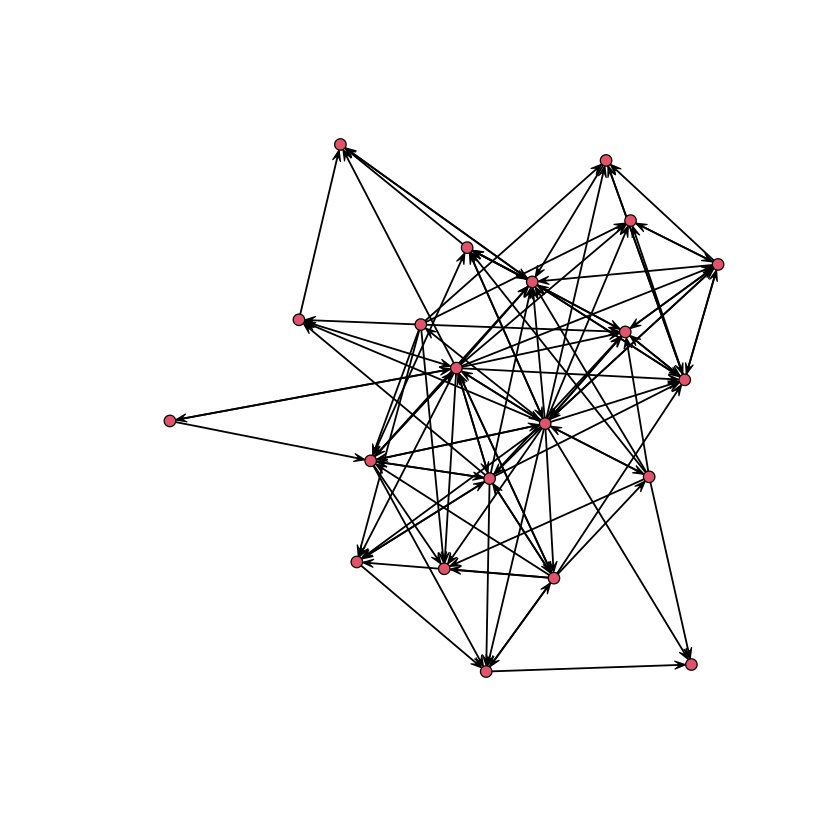

In [ ]:
# Visualize the network
plot(friend_net)

## Question 1
Estimate an ERGM with the edges and a deparment homophily parameters. Compute the conditional probability of observing a tie between two managers $i$ and $j$ belonging to the same department and interpret the result.

In [ ]:
model0 <- ergm(friend_net ~ edges + nodecov('department'))
summary(model0)
coef(model0)
theta1=coef(model0)[1]
theta2=coef(model0)[2]

Starting maximum pseudolikelihood estimation (MPLE):

Obtaining the responsible dyads.

Evaluating the predictor and response matrix.

Maximizing the pseudolikelihood.

Finished MPLE.

Evaluating log-likelihood at the estimate. 




Call:
ergm(formula = friend_net ~ edges + nodecov("department"))

Maximum Likelihood Results:

                   Estimate Std. Error MCMC % z value Pr(>|z|)    
edges              -1.46561    0.34367      0  -4.265   <1e-04 ***
nodecov.department  0.07420    0.07246      0   1.024    0.306    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 582.2  on 420  degrees of freedom
 Residual Deviance: 464.6  on 418  degrees of freedom
 
AIC: 468.6  BIC: 476.7  (Smaller is better. MC Std. Err. = 0)

edges nodecov.department 
       -1.46560786         0.07419636

In [ ]:
prob = exp(theta1 + theta2) / (1 + exp(theta1 + theta2))
prob_having_tie = exp(theta1) / (1 + exp(theta1))
paste('Probability over tie belonging to the same department is: ', prob)
paste('Probability of having a tie in general is: ', prob_having_tie)

[1] "Probability over tie belonging to the same department is:  0.199182515084951"

[1] "Probability of having a tie in general is:  0.18761111577902"

Hence, probability over tie belonging to the same department is $0.2$ that is slightly more than probability of having a tie in general $\sim 0.188$.

## Question 2 & 3
Add effects to the ERGM specified in Quetion 1 above to test simultaneously the following hypotheses:
1. A tie is more likely between managers when it reciprocates a friendship nomination (reciprocity).
2. A tie is more likely between managers when it closes a transitive two-path (transitivity).
3. A tie is more likely when the receiver has a higher in-degree (popularity)

Then Estimate the ERGM specified above and comment on the convergence of the algorithm.

In [ ]:
#The algorithm experiences near-degeneracy when evaluated with ttriple statics, so we used the gwesp
#to resolve the problem with the decay of 0.3.
model1 <- ergm(friend_net ~ edges + nodecov('department') + mutual() +  gwesp(decay=0.3,fixed=TRUE) + idegree(6))
summary(model1)

Starting maximum pseudolikelihood estimation (MPLE):

Obtaining the responsible dyads.

Evaluating the predictor and response matrix.

Maximizing the pseudolikelihood.

Finished MPLE.

Starting Monte Carlo maximum likelihood estimation (MCMLE):

Iteration 1 of at most 60:

Warning message:
“‘glpk’ selected as the solver, but package ‘Rglpk’ is not available; falling back to ‘lpSolveAPI’. This should be fine unless the sample size and/or the number of parameters is very big.”
1 
Optimizing with step length 1.0000.

The log-likelihood improved by 2.4737.

Estimating equations are not within tolerance region.

Iteration 2 of at most 60:

1 
Optimizing with step length 1.0000.

The log-likelihood improved by 0.5899.

Estimating equations are not within tolerance region.

Iteration 3 of at most 60:

1 
Optimizing with step length 1.0000.

The log-likelihood improved by 0.0797.

Convergence test p-value: 0.8233. 
Not converged with 99% confidence; increasing sample size.

Iteration 4 of at m

Call:
ergm(formula = friend_net ~ edges + nodecov("department") + mutual() + 
    gwesp(decay = 0.3, fixed = TRUE) + idegree(6))

Monte Carlo Maximum Likelihood Results:

                    Estimate Std. Error MCMC % z value Pr(>|z|)    
edges               -2.98664    0.37103      0  -8.050  < 1e-04 ***
nodecov.department   0.03436    0.04657      0   0.738 0.460665    
mutual               1.04228    0.36571      0   2.850 0.004371 ** 
gwesp.OTP.fixed.0.3  0.82636    0.22123      0   3.735 0.000187 ***
idegree6             0.42486    0.55530      0   0.765 0.444212    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 582.2  on 420  degrees of freedom
 Residual Deviance: 431.5  on 415  degrees of freedom
 
AIC: 441.5  BIC: 461.7  (Smaller is better. MC Std. Err. = 0.4358)

As the results shown above: under the significance of $0.05$ we can see that popularity measured as number of nodes with in degree $6$ has no influence on the model, as opposed to transitivity and reciprocity which have a positive influence on the model.

### Question 4 & 5
Evaluate the goodness of fit of the model according to four different auxiliary statistics. Comment on the results. Then interpret the estimated parameters.

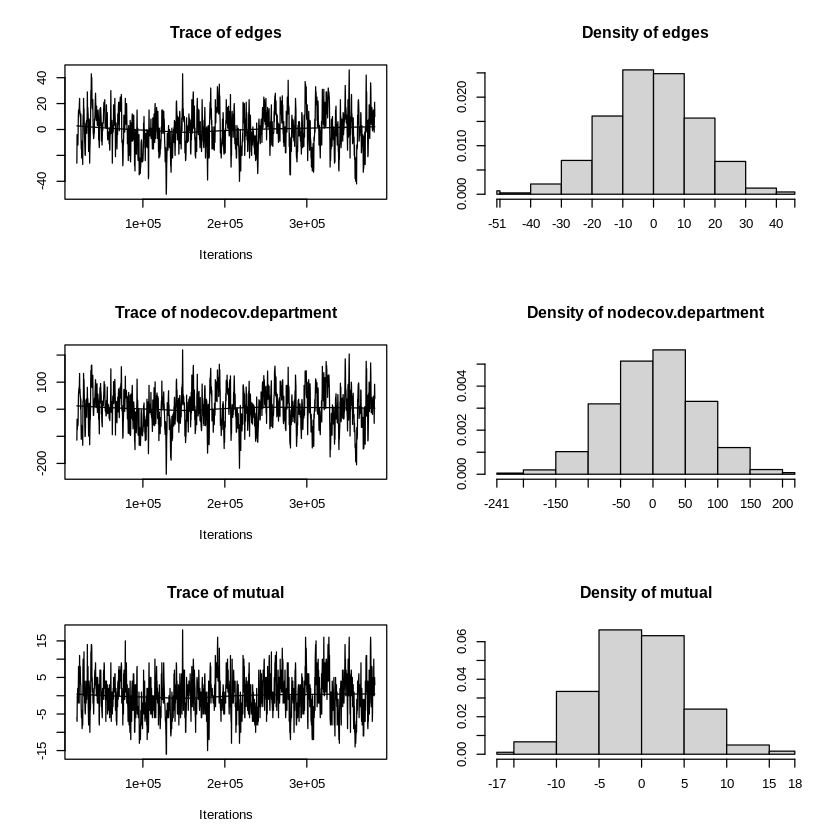

Sample statistics summary:

Iterations = 19456:382976
Thinning interval = 256 
Number of chains = 1 
Sample size per chain = 1421 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

                        Mean     SD Naive SE Time-series SE
edges               -0.10345 14.576   0.3867        1.00118
nodecov.department   2.45109 67.392   1.7878        4.69487
mutual               0.06897  5.399   0.1432        0.34353
gwesp.OTP.fixed.0.3  0.15164 22.977   0.6095        1.60320
idegree6             0.06685  1.919   0.0509        0.07789

2. Quantiles for each variable:

                       2.5%    25%     50%   75%  97.5%
edges                -29.00 -10.00  0.0000 10.00  28.00
nodecov.department  -132.00 -42.00  3.0000 48.00 131.50
mutual               -10.00  -4.00  0.0000  4.00  11.00
gwesp.OTP.fixed.0.3  -44.28 -15.67 -0.1213 15.28  44.81
idegree6              -3.00  -1.00  0.0000  1.00   4.00


Are sample statistics significantly dif

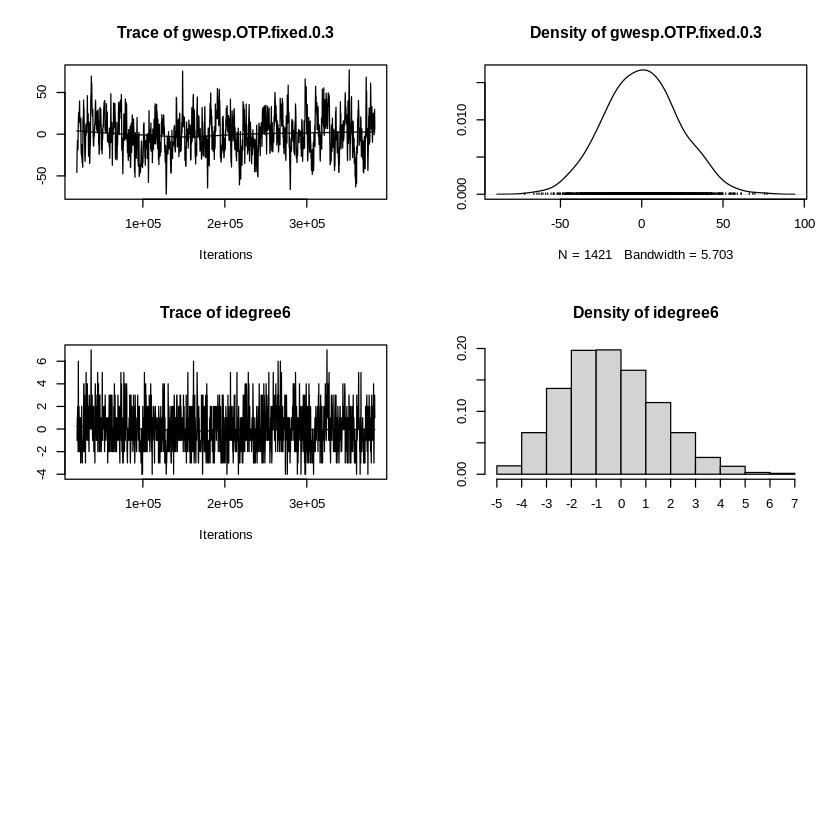

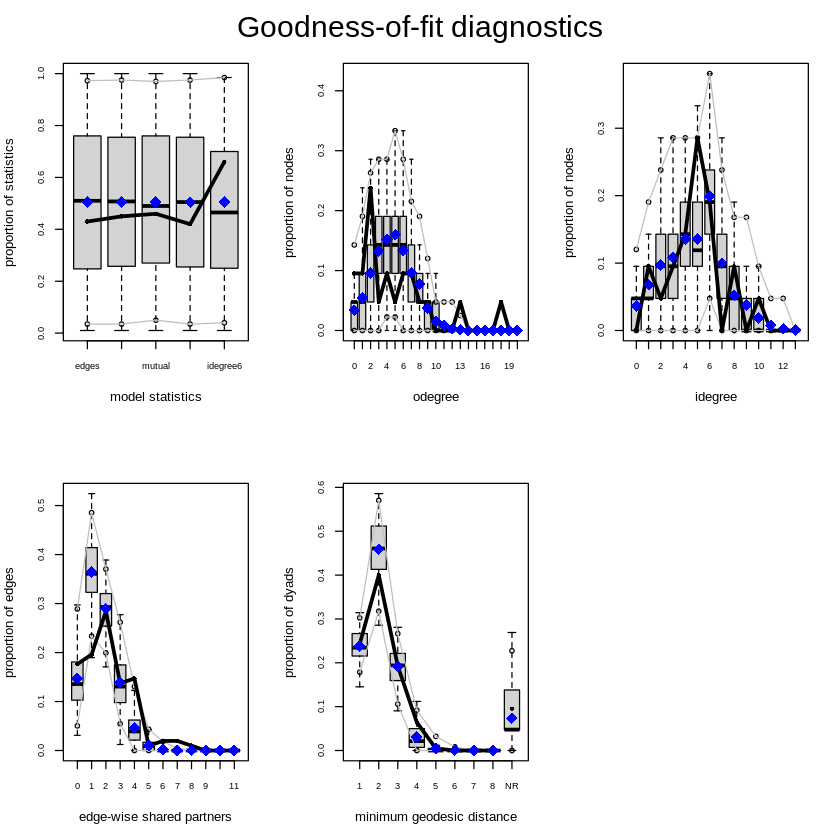

In [ ]:
mcmc.diagnostics(model1)
gof_results = gof(model1)
par(mfrow=c(2,3),mar=c(5, 4, 4, 2))
plot(gof_results)


The out degree distribution isn't accurately describing the real network. The in degree fits the network faithfully most of the time. The edge-wise shared partners does not accurately describe the network for values under 5. The same behavior is seen in the distribution of the minimum geodesic distance.

***Interpret the estimated parameters***

Even though the statics of the real network don't always fall into the 25%-75% quantile, they are contained most of the time in the 95% confidence interval. On the other hand, the indegree distribution seems to be a really good approximation of the real one. The density, reciprocity and transitivity have a really big statistical relevance for the estimated ergm; Edge density has a negative parameter suggesting a tendency to favor graphs with a lower number of edges, while the other two have the opposite influence. On the other hand, department homophily and popularity described through number of nodes with indegree at least 6 don't seem to have any impact on the model given their high p-values.

# Task 4
Building on the analysis in the previous tasks, we want to compare the results from MQ-QAP and ERGM.

1. Replicate the hypotheses in Task 1(2) using ERGM, with and without the structural terms we specified in Task 3.2. Comment on the similarity and difference of the results using ERGM compared with those using MR-QAP.

2. Could you think of another hypothesis that could be tested using ERGMs, but not with MR-QAP? State your hypothesis and provide the mathematical formula and the graphical representation of the effect that you need to include in the ERGM to test the hypothesis.

In [34]:
# Creating a network object
friend_net1 <- network(f.matrix,directed=TRUE)

# Adding attributes
friend_net1 %v% "age" <- attributes$nodeAge
friend_net1 %v% "tenure" <- attributes$nodeTenure
friend_net1 %v% "level" <- attributes$nodeLevel
friend_net1 %v% "department" <- attributes$nodeDepartment
friend_net1 %e% "advice" <-advice.matrix
friend_net1 %e% "tenure" <- tenure.matrix

friend_net1

 Network attributes:
  vertices = 21 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 102 
    missing edges= 0 
    non-missing edges= 102 

 Vertex attribute names: 
    age department level tenure vertex.names 

 Edge attribute names: 
    advice tenure 

In [39]:
m1=ergm(friend_net1 ~ edgecov(advice.matrix) + nodecov('department') +
          edgecov(tenure.matrix) + edgecov(age_dif.matrix))
summary(m1)

Starting maximum pseudolikelihood estimation (MPLE):

Obtaining the responsible dyads.

Evaluating the predictor and response matrix.

Maximizing the pseudolikelihood.

Finished MPLE.

Evaluating log-likelihood at the estimate. 




Call:
ergm(formula = friend_net1 ~ edgecov(advice.matrix) + nodecov("department") + 
    edgecov(tenure.matrix) + edgecov(age_dif.matrix))

Maximum Likelihood Results:

                        Estimate Std. Error MCMC % z value Pr(>|z|)    
edgecov.advice.matrix   0.456095   0.222352      0   2.051 0.040245 *  
nodecov.department     -0.173048   0.045855      0  -3.774 0.000161 ***
edgecov.tenure.matrix   0.007704   0.013838      0   0.557 0.577732    
edgecov.age_dif.matrix -0.063351   0.015080      0  -4.201  < 1e-04 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 582.2  on 420  degrees of freedom
 Residual Deviance: 457.4  on 416  degrees of freedom
 
AIC: 465.4  BIC: 481.6  (Smaller is better. MC Std. Err. = 0)

As in the MR-QAP test, there is evidence that advice-seeking and friendship correlate positively. The results about tenure are exactly the same, while homophily of department has a negative influence. Finally, in this model the age difference impact as a relevant negative predictor.

In [40]:
m2 = ergm(friend_net1 ~ edgecov(advice.matrix) + nodecov('department') +  edgecov(tenure.matrix)
          + edgecov(age_dif.matrix) + edges  + mutual() +
            gwesp(decay=0.3,fixed=TRUE) + idegree(6))
summary(m2)

Starting maximum pseudolikelihood estimation (MPLE):

Obtaining the responsible dyads.

Evaluating the predictor and response matrix.

Maximizing the pseudolikelihood.

Finished MPLE.

Starting Monte Carlo maximum likelihood estimation (MCMLE):

Iteration 1 of at most 60:

1 
Optimizing with step length 1.0000.

The log-likelihood improved by 2.1124.

Estimating equations are not within tolerance region.

Iteration 2 of at most 60:

1 
Optimizing with step length 1.0000.

The log-likelihood improved by 0.1810.

Estimating equations are not within tolerance region.

Iteration 3 of at most 60:

1 
Optimizing with step length 1.0000.

The log-likelihood improved by 0.1680.

Estimating equations are not within tolerance region.

Iteration 4 of at most 60:

1 
Optimizing with step length 1.0000.

The log-likelihood improved by 0.1105.

Estimating equations are not within tolerance region.

Iteration 5 of at most 60:

1 
Optimizing with step length 1.0000.

The log-likelihood improved by 0.1

Call:
ergm(formula = friend_net1 ~ edgecov(advice.matrix) + nodecov("department") + 
    edgecov(tenure.matrix) + edgecov(age_dif.matrix) + edges + 
    mutual() + gwesp(decay = 0.3, fixed = TRUE) + idegree(6))

Monte Carlo Maximum Likelihood Results:

                       Estimate Std. Error MCMC % z value Pr(>|z|)    
edgecov.advice.matrix   0.61626    0.22667      0   2.719  0.00655 ** 
nodecov.department      0.01936    0.05375      0   0.360  0.71875    
edgecov.tenure.matrix   0.02454    0.01428      0   1.718  0.08574 .  
edgecov.age_dif.matrix -0.02315    0.01354      0  -1.710  0.08727 .  
edges                  -3.11867    0.48181      0  -6.473  < 1e-04 ***
mutual                  0.94621    0.37292      0   2.537  0.01117 *  
gwesp.OTP.fixed.0.3     0.74084    0.22609      0   3.277  0.00105 ** 
idegree6                0.44506    0.58674      0   0.759  0.44813    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

     Null Deviance: 582.2  on 420  degre

After adding the structural terms, homophily of department and age difference become statistically  irrelevant. Advice seeking still has a positive impact on the friendship, while tenure still is statistically irrelevant.